In [693]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [694]:
SOLVER_VERSION = "data-collection-4-5000"

In [695]:
df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")

In [696]:
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")
solver_df

,input_file,solver_version,score,duration,query_count,n,m,eps,dense
0,tools/in/0000.txt,data-collection-4-5000,0.666667,0.5565,7,15,2,0.01,0.168889
1,tools/in/0001.txt,data-collection-4-5000,4.520269,8.3479,38,13,6,0.04,0.159763
2,tools/in/0002.txt,data-collection-4-5000,1.000000,1.5483,9,13,2,0.07,0.402367
3,tools/in/0003.txt,data-collection-4-5000,1.153113,3.0554,12,19,2,0.08,0.315789
4,tools/in/0004.txt,data-collection-4-5000,30.000238,17.9815,252,16,8,0.14,0.367188
...,...,...,...,...,...,...,...,...,...
4995,tools/in/4995.txt,data-collection-4-5000,23.804761,15.6772,171,12,4,0.16,0.527778
4996,tools/in/4996.txt,data-collection-4-5000,8.663177,11.6356,78,17,5,0.10,0.404844
4997,tools/in/4997.txt,data-collection-4-5000,2.213594,5.6070,22,17,7,0.02,0.487889
4998,tools/in/4998.txt,data-collection-4-5000,8.909545,10.8033,64,11,5,0.12,0.206612


In [697]:
num_cols = ["score", "duration", "n", "m", "eps", "dense", "query_count"]
solver_df[num_cols].corr()

,score,duration,n,m,eps,dense,query_count
score,1.000000,0.511820,0.154261,0.415748,0.296342,-0.137293,0.700350
duration,0.511820,1.000000,0.437827,0.779803,0.446253,-0.182250,0.862868
n,0.154261,0.437827,1.000000,0.578898,-0.008796,0.015039,0.450130
m,0.415748,0.779803,0.578898,1.000000,-0.028503,-0.027349,0.760590
eps,0.296342,0.446253,-0.008796,-0.028503,1.000000,-0.025178,0.384967
dense,-0.137293,-0.182250,0.015039,-0.027349,-0.025178,1.000000,-0.137830
query_count,0.700350,0.862868,0.450130,0.760590,0.384967,-0.137830,1.000000


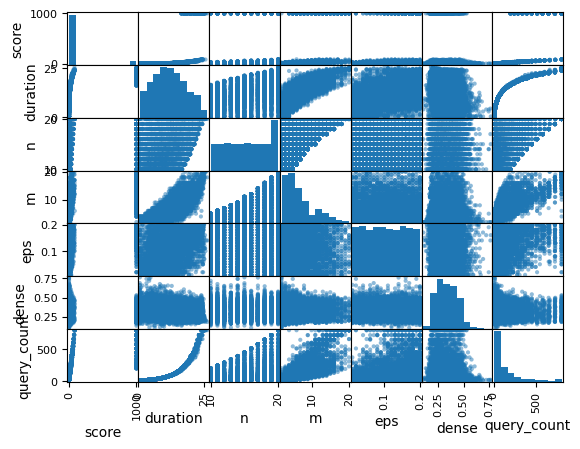

In [698]:
_ = pd.plotting.scatter_matrix(solver_df[num_cols])

In [699]:
def read_input(seed: int):
    with open(f"../tools/in/{seed:04}.txt", "r") as f:
        n, m, eps = f.readline().split()
        n, m, eps = int(n), int(m), float(eps)
        ds = []
        minos = []
        dense = 0
        for _ in range(m):
            s = f.readline().split()
            d, v = int(s[0]), list(map(int, s[1:]))
            v = [(v[2 * i], v[2 * i + 1]) for i in range(d)]
            ds.append(d)
            minos.append(v)
            dense += d
        dense /= n * n

    return n, m, eps, ds, minos, dense

In [700]:
# div = 4

# ratio_feats = []

# for seed in tqdm(range(len(solver_df))):
#     n, m, eps, ds, minos, dense = read_input(seed)

#     sizes = [(max(map(lambda p: p[0], mino)), max(map(lambda p: p[1], mino))) for mino in minos]

#     ratios = []
#     for j, mino2 in enumerate(minos):
#         s = set(mino2)
#         for i, mino1 in enumerate(minos):
#             if i <= j:
#                 continue
#             max_cnt = 0
#             for di in range(-sizes[i][0], sizes[j][0]):
#                 for dj in range(-sizes[i][1], sizes[j][1]):
#                     cnt = 0
#                     for p in mino1:
#                         v = (p[0] + di, p[1] + dj)
#                         if v in s:
#                             cnt += 1
#                     max_cnt = max(max_cnt, cnt)
#             if max_cnt == len(mino1):
#                 continue
#             ratios.append(max_cnt / len(mino1))

#     ratios.sort()
#     # ratio_ave = sum(ratios) / len(ratios)
#     ratio_max = max(ratios)
#     # ratio_feat = [ratio_ave, ratio_max] + [ratios[len(ratios) * i // div] for i in range(1, div)]
#     ratio_feat = [ratio_max]
#     ratio_feats.append(ratio_feat)

In [701]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression, Lasso

df = pd.read_csv("../log/database.csv")
input_df = pd.read_csv("../log/input.csv")
solver_df = pd.merge(df[df.solver_version == SOLVER_VERSION], input_df, how="left", on="input_file")

# ratio_cols = [f"ratio_feat_{i}" for i in range(len(ratio_feats[0]))]
# ratios_df = pd.DataFrame(ratio_feats, index=solver_df.index, columns=ratio_cols)
# solver_df = pd.concat([solver_df, ratios_df], axis=1)
solver_df.loc[:, ["mino_size"]] = solver_df.dense * (solver_df.n ** 2) / solver_df.m
solver_df.head()

,input_file,solver_version,score,duration,query_count,n,m,eps,dense,mino_size
0,tools/in/0000.txt,data-collection-4-5000,0.666667,0.5565,7,15,2,0.01,0.168889,19.00
1,tools/in/0001.txt,data-collection-4-5000,4.520269,8.3479,38,13,6,0.04,0.159763,4.50
2,tools/in/0002.txt,data-collection-4-5000,1.000000,1.5483,9,13,2,0.07,0.402367,34.00
3,tools/in/0003.txt,data-collection-4-5000,1.153113,3.0554,12,19,2,0.08,0.315789,57.00
4,tools/in/0004.txt,data-collection-4-5000,30.000238,17.9815,252,16,8,0.14,0.367188,11.75


In [702]:
solver_df.groupby(["m", "eps"]).query_count.agg(
    ["max", "median", "min"]
).reset_index().pivot_table(["max", "median", "min"], "m", "eps")

max                                                                 \
eps   0.01   0.02   0.03   0.04   0.05   0.06   0.07   0.08   0.09   0.10   
m                                                                           
2     14.0   38.0   28.0   31.0   52.0   28.0   42.0   25.0   42.0   86.0   
3     16.0   20.0   28.0   38.0   38.0   42.0   64.0   64.0   78.0   86.0   
4     22.0   25.0   47.0   64.0   71.0   71.0  141.0   95.0  155.0  338.0   
5     25.0   52.0   52.0  288.0   78.0   86.0  105.0  105.0  208.0  242.0   
6     42.0  288.0   71.0   71.0   71.0  128.0   95.0  171.0  252.0  155.0   
7     52.0   64.0   95.0  116.0   95.0  306.0  128.0  208.0  338.0  208.0   
8     52.0   95.0   86.0  105.0   78.0  171.0  141.0  337.0  252.0  208.0   
9    105.0   78.0  105.0   95.0  128.0  141.0  171.0  189.0  229.0  252.0   
10   116.0  155.0  105.0  141.0  116.0  371.0  208.0  306.0  189.0  278.0   
11   105.0   95.0  155.0  189.0  189.0  371.0  278.0  450.0  409.0  371.0   
12    95.0  512.0  208.0  189.0  371.0  252.0  278.0  306.0  306.0  800.0   
13   116.0  141.0  128.0  371.0  155.0  337.0  409.0  337.0  409.0  337.0   
14   141.0  229.0  141.0  229.0  450.0  306.0  306.0  545.0  660.0  799.0   
15   155.0  229.0  229.0  306.0  306.0  648.0  371.0  337.0  409.0  660.0   
16   189.0  229.0  306.0  337.0  409.0  409.0    NaN  371.0  800.0  371.0   
17   141.0  229.0  171.0  722.0  450.0  722.0  800.0  726.0  371.0  722.0   
18   371.0  800.0  189.0  450.0  800.0  800.0  722.0  800.0  450.0  722.0   
19   189.0  278.0  409.0  450.0  800.0  495.0  800.0  495.0  800.0  800.0   
20     NaN  800.0    NaN  495.0  660.0  800.0    NaN  800.0    NaN  799.0   

     ...    min                                                                 
eps  ...   0.11   0.12   0.13   0.14   0.15   0.16   0.17   0.18   0.19   0.20  
m    ...                                                                        
2    ...    7.0    7.0    7.0    7.0    8.0    7.0    7.0    7.0    7.0    7.0  
3    ...    8.0   18.0   10.0   14.0   18.0    7.0   12.0   20.0   12.0   28.0  
4    ...   18.0   25.0   14.0   18.0   20.0   28.0   22.0   22.0   28.0   42.0  
5    ...   34.0   34.0   25.0   58.0   31.0   47.0   38.0   58.0   34.0   71.0  
6    ...   34.0   34.0   52.0   58.0   78.0   64.0   95.0   95.0   78.0   95.0  
7    ...   64.0   47.0   71.0   86.0   58.0   64.0  105.0  128.0  128.0  141.0  
8    ...  105.0   95.0  105.0   71.0   86.0  116.0  141.0  128.0  155.0  116.0  
9    ...  105.0  141.0  105.0  141.0  141.0  155.0  155.0  208.0  229.0  278.0  
10   ...  171.0  116.0  171.0  155.0  229.0  171.0  278.0  208.0  337.0  189.0  
11   ...  155.0  189.0  229.0  229.0  208.0  208.0  278.0  252.0  371.0  450.0  
12   ...  189.0  208.0  229.0  229.0  229.0  278.0  512.0  409.0  371.0  337.0  
13   ...  252.0  189.0  252.0  306.0  208.0  409.0  450.0  495.0  545.0  578.0  
14   ...  155.0  409.0  409.0  409.0  409.0  409.0  450.0  600.0  600.0  648.0  
15   ...  371.0  450.0  450.0  409.0  337.0  600.0  660.0  545.0  800.0  648.0  
16   ...  545.0  409.0  409.0  648.0  648.0  722.0  648.0  648.0  722.0  648.0  
17   ...  600.0  726.0  726.0  722.0  600.0  799.0  800.0  722.0  800.0  722.0  
18   ...  800.0  800.0    NaN  800.0  722.0  722.0  722.0  800.0  800.0  722.0  
19   ...  726.0  799.0  800.0  800.0    NaN    NaN  800.0  800.0  800.0    NaN  
20   ...  800.0  800.0  800.0  800.0  800.0  800.0    NaN    NaN  800.0  800.0  

[19 rows x 60 columns]

In [703]:
solver_df = solver_df.groupby(["n", "m", "eps"])[["query_count", "score", "duration"]].median().reset_index()
solver_df

,n,m,eps,query_count,score,duration
0,10,2,0.01,7.0,0.816497,0.51030
1,10,2,0.02,7.0,0.824163,0.51170
2,10,2,0.03,13.0,1.664101,3.32220
3,10,2,0.04,11.0,1.400280,2.30135
4,10,2,0.05,11.5,1.484924,2.56375
...,...,...,...,...,...,...
1881,20,20,0.14,800.0,1000.000000,25.37180
1882,20,20,0.15,800.0,1000.000000,24.58780
1883,20,20,0.16,800.0,1000.000000,24.75770
1884,20,20,0.19,800.0,1000.000000,24.32890


In [704]:
# solver_df[num_cols + ratio_cols].corr()

In [705]:
alphas = [0.5, 2.0]

data_df = solver_df.copy(deep=True)
data_df.loc[:, ["target"]] = data_df["query_count"]

data_df = data_df.drop(
    ["input_file", "solver_version", "score", "duration", "query_count"],
    axis=1,
    errors="ignore",
)

feature_cols = []

base_feature_cols = ["n", "m", "eps"]
# base_feature_cols = ["n", "m", "eps", "dense", "mino_size"]

# 特徴量
for col in base_feature_cols:
    # feature_cols.append(f"{col}.ln()")
    # data_df.loc[:, [f"{col}.ln()"]] = np.log(data_df[col])

    for alpha in alphas:
        feature_cols.append(f"{col}.powf({alpha})")
        data_df.loc[:, [f"{col}.powf({alpha})"]] = data_df[col] ** alpha

# feature_cols += ratio_cols

for col1 in feature_cols:
    for col2 in feature_cols:
        data_df.loc[:, [f"{col1} * {col2}"]] = data_df[col1] * data_df[col2]
        data_df.loc[:, [f"{col1} / {col2}"]] = data_df[col1] / data_df[col2]

x = data_df.drop(["target"], axis=1)
y = data_df["target"]

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

model = Ridge(alpha=1e-3)
model.fit(train_x, train_y)

# print(model.coef_)
# print(model.intercept_)
print(len(model.coef_))
print(len(list(filter(lambda x: abs(x) > 1e-10, model.coef_))))
print(model.score(train_x, train_y))
print(model.score(test_x, test_y))
expr = (
    " + ".join([f"{c:.5} * {t}" for c, t in zip(model.coef_.flatten(), x.columns)])
    + f" + {model.intercept_:.5}"
)
print(expr)
with open("../log/expr.txt", "w") as f:
    f.write(expr + "\n")

81
75
0.908291837630234
0.9233617309218188
93.502 * n + -381.9 * m + -310.85 * eps + 53.712 * n.powf(0.5) + 10.221 * n.powf(2.0) + -259.6 * m.powf(0.5) + -55.366 * m.powf(2.0) + -1770.9 * eps.powf(0.5) + -301.75 * eps.powf(2.0) + 93.502 * n.powf(0.5) * n.powf(0.5) + 0.0 * n.powf(0.5) / n.powf(0.5) + -1.18 * n.powf(0.5) * n.powf(2.0) + -16.472 * n.powf(0.5) / n.powf(2.0) + -166.55 * n.powf(0.5) * m.powf(0.5) + -85.709 * n.powf(0.5) / m.powf(0.5) + -2.7667 * n.powf(0.5) * m.powf(2.0) + -399.56 * n.powf(0.5) / m.powf(2.0) + -939.23 * n.powf(0.5) * eps.powf(0.5) + -79.973 * n.powf(0.5) / eps.powf(0.5) + -830.82 * n.powf(0.5) * eps.powf(2.0) + 0.033441 * n.powf(0.5) / eps.powf(2.0) + -1.1798 * n.powf(2.0) * n.powf(0.5) + 20.202 * n.powf(2.0) / n.powf(0.5) + 0.0052355 * n.powf(2.0) * n.powf(2.0) + 0.0 * n.powf(2.0) / n.powf(2.0) + -0.65602 * n.powf(2.0) * m.powf(0.5) + -9.9064 * n.powf(2.0) / m.powf(0.5) + -0.045097 * n.powf(2.0) * m.powf(2.0) + 6.0005 * n.powf(2.0) / m.powf(2.0) + 1.8334 * 

/Users/tatsuyaishii/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:212: LinAlgWarning: Ill-conditioned matrix (rcond=7.46655e-19): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


  38.0 58.24593397974763
  58.0 49.985208412216025
  38.0 26.108726810725784
 143.5 86.85515035071273
 116.0 78.5172088483215
  28.0 25.985417991306804
 149.5 172.31070289351305
  71.0 52.85034079756463
  28.0 36.987091337313245
 409.0 347.4420353066507


[-47.11970949794113, 897.1802025429988]

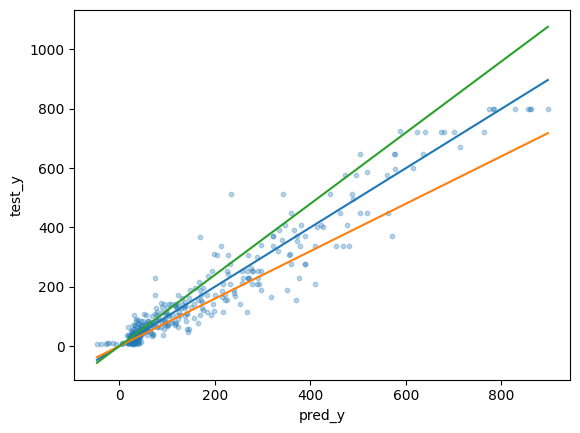

In [706]:
pred_y = model.predict(test_x)
for i in range(100, 110):
    print(f"{test_y.iloc[i]:6} {pred_y[i]}")

plt.scatter(pred_y, test_y, alpha=0.3, s=10)
plt.xlabel("pred_y")
plt.ylabel("test_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min() * 0.8, pred_y.max() * 0.8])
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min() * 1.2, pred_y.max() * 1.2])
# plt.xlim(0, 100)
# plt.ylim(0, 100)
[pred_y.min(), pred_y.max()]

In [707]:
# import torch


# class Model(torch.nn.Module):
#     def __init__(self, n_feature: int, d_model: int):
#         super().__init__()
#         self.layers = torch.nn.Sequential(
#             torch.nn.Linear(n_feature, d_model),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(d_model, d_model),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(d_model, d_model),
#             torch.nn.Sigmoid(),
#             torch.nn.Linear(d_model, 1),
#         )

#     def forward(self, x: torch.Tensor) -> torch.Tensor:
#         return self.layers.forward(x)


# train_dataset = torch.utils.data.TensorDataset(
#     torch.Tensor(train_x.values), torch.Tensor(train_y.values)
# )

# model = Model(n_feature=train_x.shape[1], d_model=64)
# model.train()

# criterion = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# data_loader = torch.utils.data.DataLoader(
#     dataset=train_dataset, shuffle=True, batch_size=16
# )

# losses = []

# for i in tqdm(range(100)):
#     loss_sum = 0
#     for X, y in data_loader:
#         optimizer.zero_grad()
#         y_hat = model.forward(X)
#         loss = criterion(y_hat, y)
#         loss.backward()
#         optimizer.step()
#         loss_sum += loss.item()

#     if (i + 1) % 10 == 0:
#         loss_sum /= len(data_loader)
#         losses.append(loss_sum)

# pred_y = model.forward(torch.Tensor(test_x.values)).detach().numpy()
# print(pred_y[:10], test_y[:10].values)
# plt.scatter(test_y, pred_y)
# plt.show()
# plt.plot(losses)
# plt.show()

In [708]:
import lightgbm as lgb
from sklearn.metrics import r2_score

params = {
    "objective": "regression",
    "metric": "rmse",
    "boosting_type": "gbdt",
    "random_state": 0,
    "verbose": -1
}

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=0)
train_set = lgb.Dataset(train_x, train_y)
valid_set = lgb.Dataset(valid_x, valid_y, reference=train_set)

model = lgb.train(params=params, train_set=train_set, valid_sets=[valid_set], num_boost_round=1000)

pred_y = model.predict(test_x, num_iteration=model.best_iteration)
print(r2_score(test_y, pred_y))

0.8940214861698502


[1.3142707058955745, 822.250948095371]

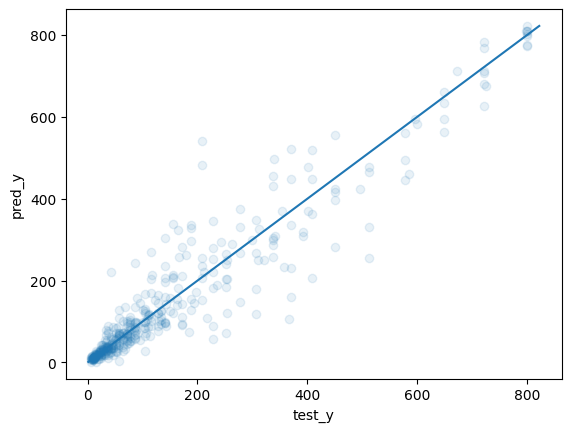

In [709]:
plt.scatter(test_y, pred_y, alpha=0.1)
plt.xlabel("test_y")
plt.ylabel("pred_y")
_ = plt.plot([pred_y.min(), pred_y.max()], [pred_y.min(), pred_y.max()])
[pred_y.min(), pred_y.max()]